In [10]:
# General Imports
import numpy as np
import csv
from datetime import datetime as time
import os

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 12,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# State Generation

In [11]:
def plot_dm(astate):

    # Init arrays
    dim = astate.shape[0]
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()


    fig = plt.figure(dpi=80)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=min(dz), vmax=max(dz))
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=min(dz), vmax=max(dz), cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    plt.show()

# Tomograpy FFN

### Read dataset

In [34]:
datadir = './data/states50000_obs100_2022-04-26_08:57:15/'
nstat = int(5e4)
nobs = 100

y = np.zeros((0,3))
X = np.zeros((0,nobs))
data_obs = np.zeros((0,2,2))

# Read states
with open(datadir+'states.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    y = np.vstack((y, np.array(np.array(line).astype('float'))))

# Read observables
with open(datadir+'observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(2,2).astype('complex128')])))

# Read states
with open(datadir+'measurements.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    X = np.vstack((X, np.array(np.array(line).astype('float'))))


X_train, X_left, y_train, y_left = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_valid, X_treasure, y_valid, y_treasure = train_test_split(
    X_left, y_left, test_size=0.4, random_state=42)

X.shape
y.shape
X_train.shape[0]
X_valid.shape[0]
X_treasure.shape[0]

50000it [00:01, 46593.99it/s] 
100it [00:00, 60655.16it/s]
50000it [01:13, 678.75it/s] 


(50000, 100)

(50000, 3)

35000

9000

6000

In [35]:
class CustomDataset(Dataset):

  def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        # Select sample
        X = self.X[index]

        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [36]:
tomography_train_dataset = CustomDataset(X_train, y_train)
tomography_valid_dataset = CustomDataset(X_valid, y_valid)

In [37]:
# Define the batch size
BATCH_SIZE = 64

# Create data loaders from the datasets for the current task
# Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Feed Forward Neural Network

In [ ]:
class FeedForwardNet(nn.Module):

  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
    nn.Linear(100, 64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,3),
    )

  def forward(self, x):
    return self.layers(x)

In [39]:
# Function for training the network
def train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_batch_loss = np.array([])
            for valid_batch in valid_dataloader:
                valid_measurements, valid_target = valid_batch[0].to(device), valid_batch[1].to(device)
                valid_outputs = net(valid_measurements)
                valid_loss = criterion(valid_outputs, valid_target).clone().detach().cpu().numpy()
                valid_batch_loss = np.append(valid_batch_loss, valid_loss)
            valid_losses = np.append(valid_losses, np.mean(valid_batch_loss))
    return train_losses, valid_losses

In [40]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net = FeedForwardNet().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)

train_losses, valid_losses = train(net, 2, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

cpu


100%|██████████| 2/2 [00:26<00:00, 13.48s/it]


In [41]:
def plot_train_stats(train_losses, valid_losses, batchsize):
    it_per_epoch = X_train.shape[0] // batchsize

    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.legend()
    a=plt.title(f'Loss (MSE) on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    plt.show()

plot_train_stats(train_losses, valid_losses, BATCH_SIZE)

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


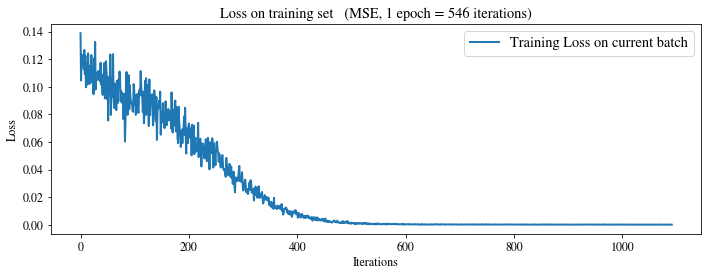

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


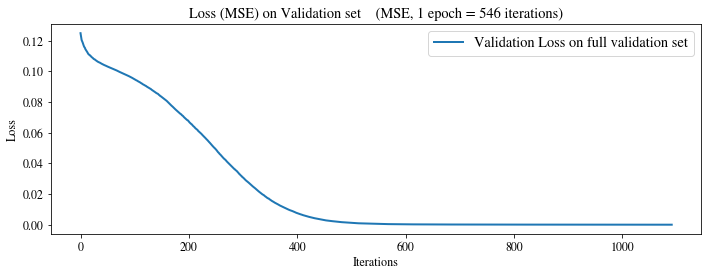

In [42]:
plot_train_stats(train_losses, valid_losses, BATCH_SIZE)

In [44]:
train_losses[-1]
valid_losses[-1]

2.289396070409566e-05

6.46651937911104e-05

# Inference

#### Random state generation

In [49]:
def create_pure_rho(nqubits):
    dim = 2**nqubits
    psi =   np.random.uniform(low=-1, high=1, size=dim) +\
            1j * np.random.uniform(low=-1, high=1, size=dim) 
    rho = np.outer(psi, psi.T.conjugate())

    # Trace condition
    rho /= np.trace(rho)

    # Positive semi-definiteness condition
    if not np.all(np.linalg.eigvals(rho) >= 0):
        #print('recursive')
        return create_pure_rho(nqubits)
    return rho

def partial_trace(rho):
    #trace is independent of basis choice of traced subsystem
    basis = np.eye(2)
    reduced = np.zeros((2,2), dtype=np.complex128)
    for bvec in basis:
        bra = np.kron(np.eye(2), bvec)
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

# Wrapper function
def random_rho(pure):
    if pure:
        return create_pure_rho(nqubits=1)
    else:
        return partial_trace(create_pure_rho(nqubits=2))

def perform_measurements(rho, observables):
    return np.real( np.trace(observables.dot(rho), axis1=1, axis2=2) )

# Define Pauli matrices
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

pauli_matrices = np.array([s1, s2, s3])

def bloch2mat(vec):
    assert vec.shape[0] == 3
    r_sig = vec[0] * s1 + vec[1] * s2 + vec[2] * s3
    return np.array((np.eye(2) + r_sig) /2)

#### Do inference

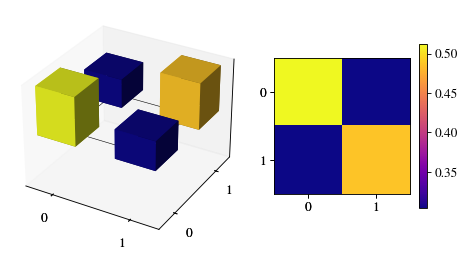

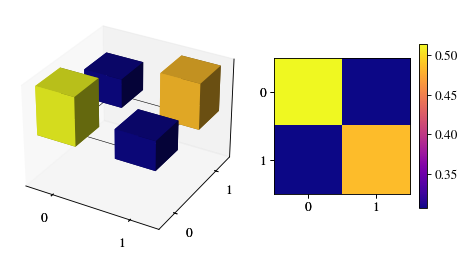

In [64]:
rho_infer = random_rho(pure=False)
m_infer = torch.Tensor(perform_measurements(rho_infer, data_obs))
bloch_pred = net.forward(m_infer.to(device)).detach().cpu().numpy()
rho_pred = bloch2mat(bloch_pred)

plot_dm(np.real(rho_infer))
plot_dm(np.real(rho_pred))

17.04.

Verbesserungsansätze: 
- netzwerk vergrößern
  - nichts gebracht
- andere loss function mit mehr gewicht für outliers
  - bereits MSE verwendet, was mehr weight auf outliers gibt as MAE=L1, konvergiert bei 0.02 training loss
  - MAE bringt nichts, resultiert in 0.7 training loss
- berücksichtigen, dass information auf offdiagonaler redundant ist
  - siehe neues notebook error von bloch vektoren

Briegel fragen was genau es bringt im AE nicht über die dichtematrix zu gehen sondern direkt auf kompakteste repräsentation zu lernen.

20.04.

- ausschließlich die lr von 0.001 auf 0.05 erhöht, lernt gut.
- netzwerk lernt auch mit kleinerer architektur 100-64-32-3

- wieviele n_obs mindestens notwendig?
